### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from fuzzywuzzy import fuzz
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)

In [2]:
import sys

def displayProgress(instance, maxValue):
    percentage = round((instance / maxValue * 100), 3)
    printStatement = str(instance) + "/" + str(maxValue) + " checks completed (" + str(percentage) + "%)"
    sys.stdout.write("\r" + printStatement)
    sys.stdout.flush()

In [3]:
dataset = pd.read_csv("Jobs.csv")

In [4]:
dataset = dataset.drop(dataset.columns[0], axis=1)

In [5]:
dataset.head()

,title,company,announcement,description
0,"Senior Analyst, Data Science and Analytics",TransUnion,The Muse,"TransUnion's Job Applicant Privacy Notice What We'll Bring... At TransUnion, we strive to build..."
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"About The Opportunity We're all about connecting hungry diners with our network of over 300,000..."
2,Lead Data Science Analyst,Discover Financial Services,LinkedIn,"Discover. A brighter future. With us, you’ll do meaningful work from Day 1. Our collaborative c..."
3,Data Science Intern,AbelsonTaylor,Startup Jobs,Are you a 2023 college graduate or rising college senior? AbelsonTaylor is looking for 9 Chicago...
4,Data Scientist,NORC at the University of Chicago,SimplyHired,"JOB DESCRIPTION: At NORC, Data Scientists play a key role in working with our research teams to..."


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790 entries, 0 to 789
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         790 non-null    object
 1   company       790 non-null    object
 2   announcement  790 non-null    object
 3   description   790 non-null    object
dtypes: object(4)
memory usage: 24.8+ KB


### Make title and description to lowercase for analysis

In [7]:
dataset.head()

,title,company,announcement,description
0,"Senior Analyst, Data Science and Analytics",TransUnion,The Muse,"TransUnion's Job Applicant Privacy Notice What We'll Bring... At TransUnion, we strive to build..."
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"About The Opportunity We're all about connecting hungry diners with our network of over 300,000..."
2,Lead Data Science Analyst,Discover Financial Services,LinkedIn,"Discover. A brighter future. With us, you’ll do meaningful work from Day 1. Our collaborative c..."
3,Data Science Intern,AbelsonTaylor,Startup Jobs,Are you a 2023 college graduate or rising college senior? AbelsonTaylor is looking for 9 Chicago...
4,Data Scientist,NORC at the University of Chicago,SimplyHired,"JOB DESCRIPTION: At NORC, Data Scientists play a key role in working with our research teams to..."


In [8]:
dataset["title"] = dataset["title"].str.lower()

In [9]:
dataset["description"] = dataset["description"].str.lower()

In [10]:
dataset.head()

,title,company,announcement,description
0,"senior analyst, data science and analytics",TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build..."
1,senior data scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000..."
2,lead data science analyst,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c..."
3,data science intern,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...
4,data scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to..."


### New column for Scientist and Analyst (Target variable)

In [11]:
def IsScientistOrAnalyst(row):
    result = ""
    
    if "science" in row["title"] or "scientist" in row["title"]:
        result = "Scientist"
    else:
        result = "Analyst"
    return result

In [12]:
dataset['job'] = dataset.apply(IsScientistOrAnalyst, axis=1)

In [13]:
dataset.head()

,title,company,announcement,description,job
0,"senior analyst, data science and analytics",TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build...",Scientist
1,senior data scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000...",Scientist
2,lead data science analyst,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c...",Scientist
3,data science intern,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...,Scientist
4,data scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to...",Scientist


In [14]:
dataset['job'].value_counts()

Analyst      462
Scientist    328
Name: job, dtype: int64

Setting Ranking

- VP
- Director
- Principal
- Lead/Manager
- Senior
- Normal/Staff
- Junior/Associate
- Intern

In [15]:
def NormaliseJobTitle(row):
    title = row["title"]    
    result = ""
    
    if row["job"] == "Scientist":
        result = "Scientist"
    elif row["job"] == "Analyst":
        result = "Analyst"
    
    if "vp" in title or "vice president" in title:
        result = f"VP Data {result}"
    elif "director" in title:
        result = f"Director Data {result}"
    elif "principal" in title:
        result = f"Principal Data {result}"
    elif "lead" in title or "founding" in title:
        result = f"Lead Data {result}"        
    elif "senior" in title or "sr" in title:
        result = f"Senior Data {result}"
    elif "staff" in title:
        result = f"Staff Data {result}"
    elif "jr" in title or "junior" in title:
        result = f"Junior Data {result}"
    elif "intern" in title:
        result = f"Intern Data {result}"
    else:
        result = f"Staff Data {result}"
    
    return result

In [16]:
dataset['title'] = dataset.apply(NormaliseJobTitle, axis=1)

In [17]:
dataset.head()

,title,company,announcement,description,job
0,Senior Data Scientist,TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build...",Scientist
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000...",Scientist
2,Lead Data Scientist,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c...",Scientist
3,Intern Data Scientist,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...,Scientist
4,Staff Data Scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to...",Scientist


In [18]:
dataset["title"].value_counts()

Staff Data Analyst          317
Staff Data Scientist        193
Senior Data Analyst          92
Senior Data Scientist        89
Intern Data Analyst          17
Lead Data Analyst            15
Lead Data Scientist          13
Intern Data Scientist        13
Junior Data Analyst          10
Director Data Scientist       8
Principal Data Scientist      6
Principal Data Analyst        5
Director Data Analyst         5
VP Data Scientist             3
Junior Data Scientist         3
VP Data Analyst               1
Name: title, dtype: int64

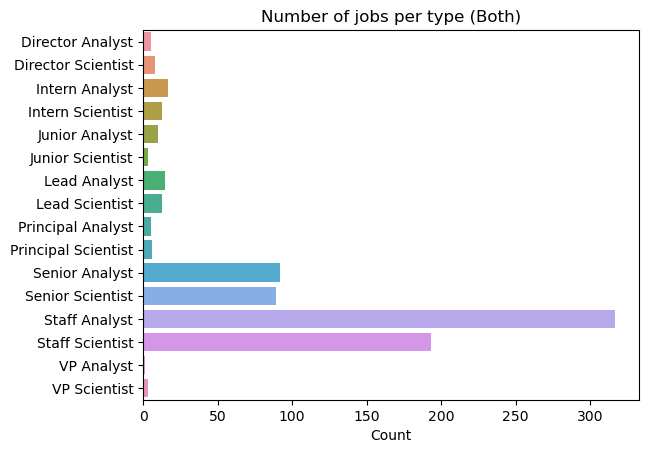

In [19]:
dataset_dict = {}

for index, row in dataset.iterrows():
    title_split = row["title"].split()
    dict_key = f"{title_split[0]} {title_split[2]}"

    if dict_key in dataset_dict:
        dataset_dict[dict_key] += 1
    else:
        dataset_dict[dict_key] = 1

dataset_dict = dict(sorted(dataset_dict.items()))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Number of jobs per type (Both)")
plt.xlabel("Count")
plt.show()

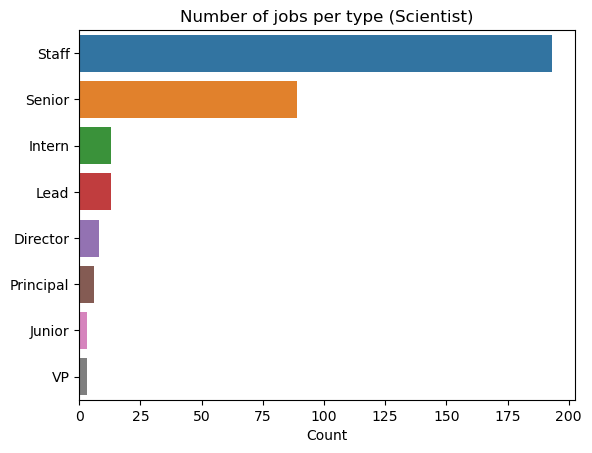

In [20]:
dataset_dict = {}

for index, row in dataset.iterrows():
    title_split = row["title"].split()
    
    if title_split[2] == "Scientist":
        dict_key = f"{title_split[0]}"

        if dict_key in dataset_dict:
            dataset_dict[dict_key] += 1
        else:
            dataset_dict[dict_key] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Number of jobs per type (Scientist)")
plt.xlabel("Count")
plt.show()

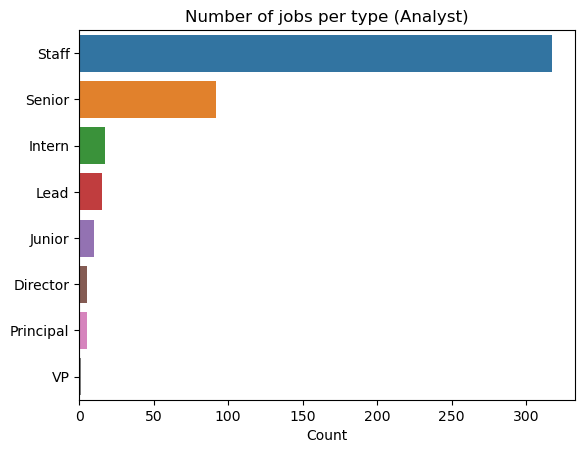

In [21]:
dataset_dict = {}

for index, row in dataset.iterrows():
    title_split = row["title"].split()
    
    if title_split[2] == "Analyst":
        dict_key = f"{title_split[0]}"

        if dict_key in dataset_dict:
            dataset_dict[dict_key] += 1
        else:
            dataset_dict[dict_key] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Number of jobs per type (Analyst)")
plt.xlabel("Count")
plt.show()

### Analyse Skills

In [22]:
# list of skills to match
skills = ["Python","SQL","Jupyter","NumPy","Pandas","Matplotlib","Seaborn","SciPy","Scikit-Learn","TensorFlow","PyTorch","Keras","XGBoost",
          "LightGBM","Plotly","Dask","Spark","Hadoop","AWS","Google Cloud","Azure","IBM Watson","NLTK","OpenCV","Gensim","StatsModels","Theano",
          "Caffe","Keras-Tuner","Auto-Keras","Auto-Sklearn","Shap","ELI5","Bokeh","Folium","ggplot","plotnine","Geopandas","Datashader",
          "Yellowbrick","H2O.ai","Flask","Dash","Streamlit","FastAPI","PySpark","TensorBoard","cuDF","NetworkX","BeautifulSoup","Scrapy","Numba",
          "Cython", "Apache", "Git","Java","Excel","Power BI","Tableau","Linux"]

singlechar_skills = ["R", "C++", "C#"]

In [23]:
def match_phrases(description, phrases, fuzz_type, scoring):    
    matched_phrase = []
    
    for i in range(len(phrases)):
        if fuzz_type[i] == "ptsr":
            for phrase in phrases[i]:
                if fuzz.partial_token_set_ratio(description, phrase) >= scoring:
                    matched_phrase.append(phrase)            
        elif fuzz_type[i] == "tsr":
            for phrase in phrases[i]:
                if fuzz.token_set_ratio(description, phrase) >= scoring:
                    matched_phrase.append(phrase)  
    
    # Only return matches once
    unique_matches = list(set(matched_phrase))
    
    return unique_matches

In [24]:
dataset["skills"] = dataset["description"].apply(lambda x: match_phrases(description=x, 
                                                                         phrases=[skills, singlechar_skills], 
                                                                         fuzz_type=["ptsr", "tsr"],
                                                                         scoring=90))

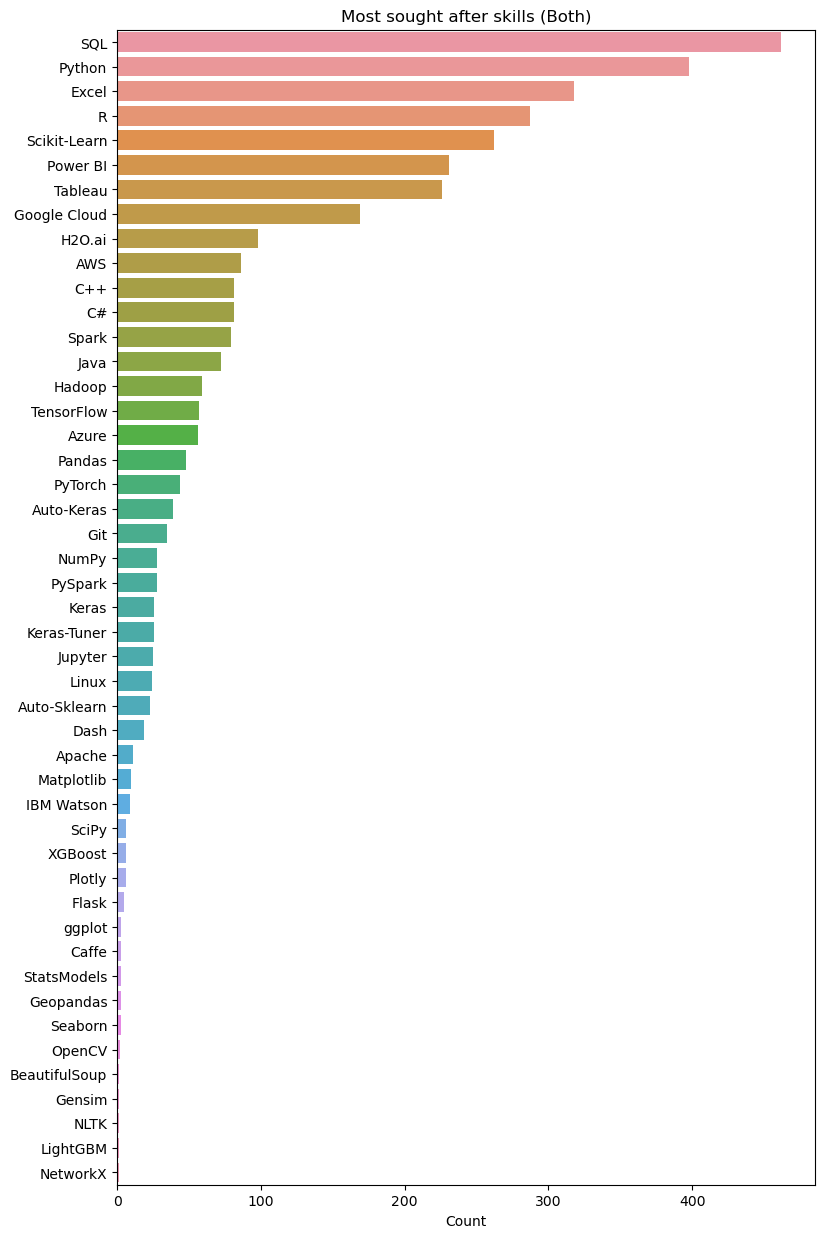

In [25]:
dataset_dict = {}

for index, row in dataset.iterrows():
    for i in row["skills"]:
        if i in dataset_dict:
            dataset_dict[i] += 1
        else:
            dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after skills (Both)")
plt.xlabel("Count")
plt.show()

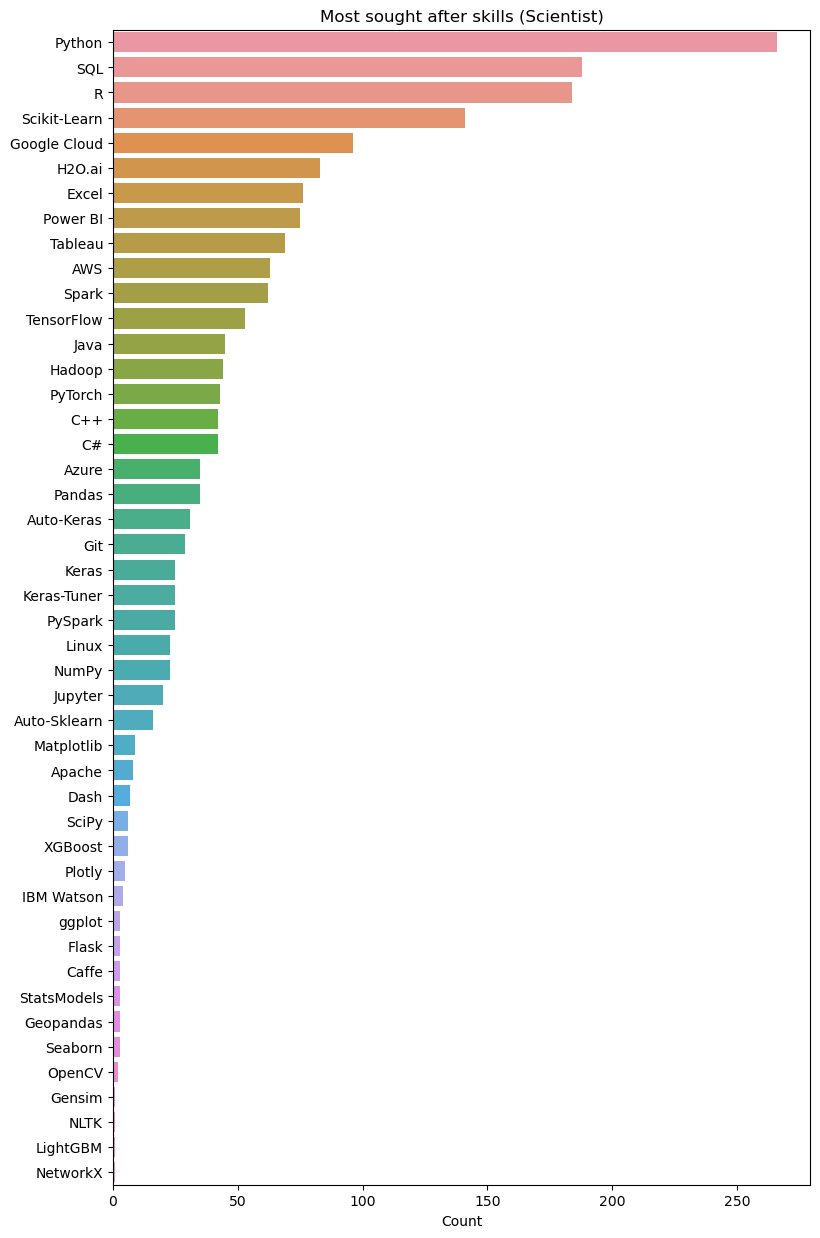

In [26]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Scientist":
        for i in row["skills"]:
            if i in dataset_dict:
                dataset_dict[i] += 1
            else:
                dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after skills (Scientist)")
plt.xlabel("Count")
plt.show()

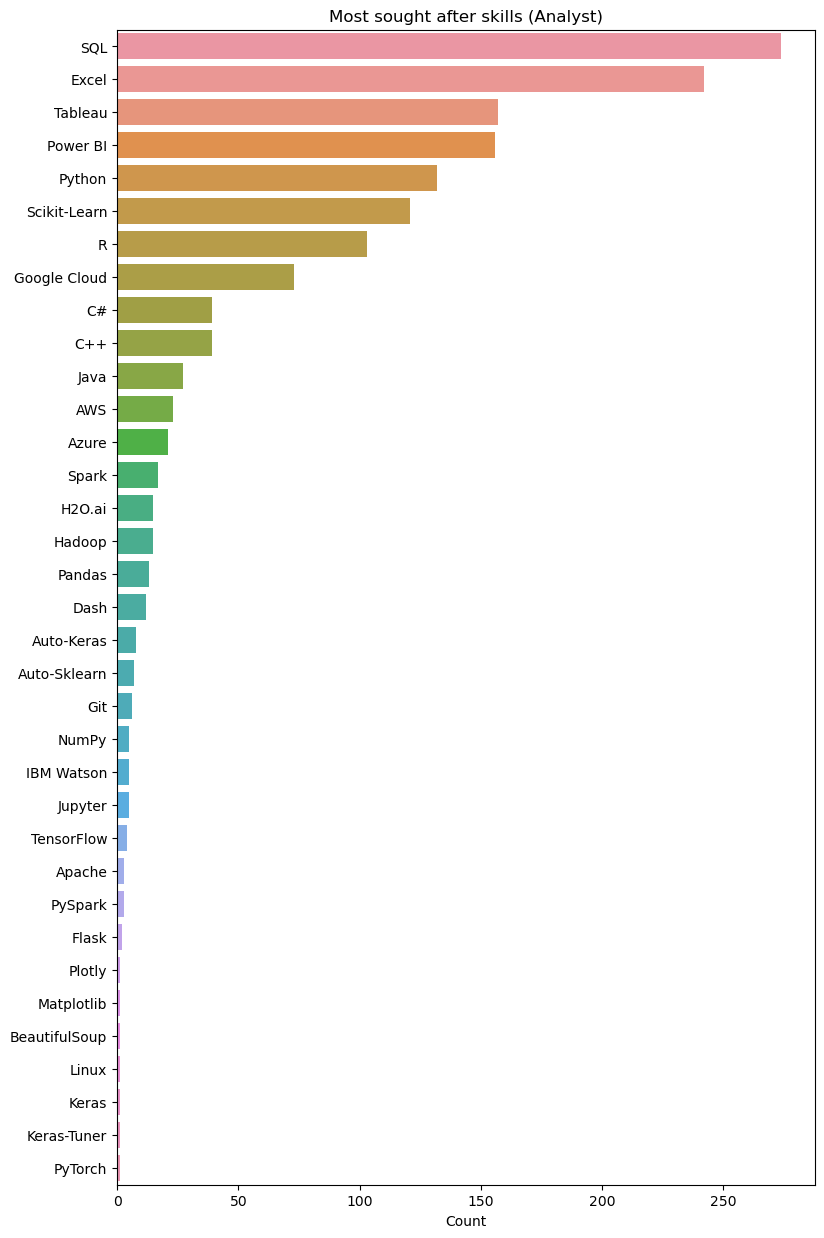

In [27]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Analyst":
        for i in row["skills"]:
            if i in dataset_dict:
                dataset_dict[i] += 1
            else:
                dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after skills (Analyst)")
plt.xlabel("Count")
plt.show()

### Analyse Tasks

In [28]:
tasks = ["Python programming","Statistics","Probability","Machine learning","Data visualization","Preprocessing","Cleaning","Database management",
         "Analysis","Modeling","Deep learning","Data engineering","Visualization","Manipulation","Machine learning","Storage","Cloud computing",
         "ETL","Warehousing","Governance","Security","Storytelling","Product development","Natural language processing","Computer vision",
         "Business intelligence","Mining","Feature engineering","Time series analysis","Regression analysis","Classification algorithms",
         "Clustering algorithms","Neural networks","Decision trees","Random forests","Support vector machines","K-nearest neighbors",
         "Reinforcement learning","Hyperparameter tuning","Ensemble learning","Transfer learning","Unsupervised learning","Supervised learning",
         "Exploratory data analysis","Quality control","Data interpretation","Collaboration","Communication","Project management",
         "Agile development","Software engineering","Version control","Debugging","Troubleshooting","Continuous integration and deployment",
         "Optimization", 'Deployment']

In [29]:
dataset["tasks"] = dataset["description"].apply(lambda x: match_phrases(description=x, 
                                                                        phrases=[tasks], 
                                                                        fuzz_type=["tsr"],
                                                                        scoring=90))

In [30]:
dataset.head()

,title,company,announcement,description,job,skills,tasks
0,Senior Data Scientist,TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build...",Scientist,"[R, SQL, Python, Scikit-Learn, Excel]","[Statistics, Regression analysis, Data engineering, Mining, Modeling, Time series analysis, Anal..."
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000...",Scientist,"[PySpark, AWS, SQL, Python, Pandas, Power BI, NumPy, Scikit-Learn, Excel]","[Statistics, Visualization, Data engineering, Feature engineering, Neural networks, Analysis, Ma..."
2,Lead Data Scientist,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c...",Scientist,[],"[Statistics, Data engineering, Modeling, Project management, Analysis, Machine learning, Collabo..."
3,Intern Data Scientist,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...,Scientist,"[Scikit-Learn, Excel]","[Visualization, Modeling, Project management, Business intelligence, Data visualization]"
4,Staff Data Scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to...",Scientist,"[R, Plotly]","[Computer vision, Statistics, Visualization, Modeling, Cleaning, Project management, Analysis, M..."


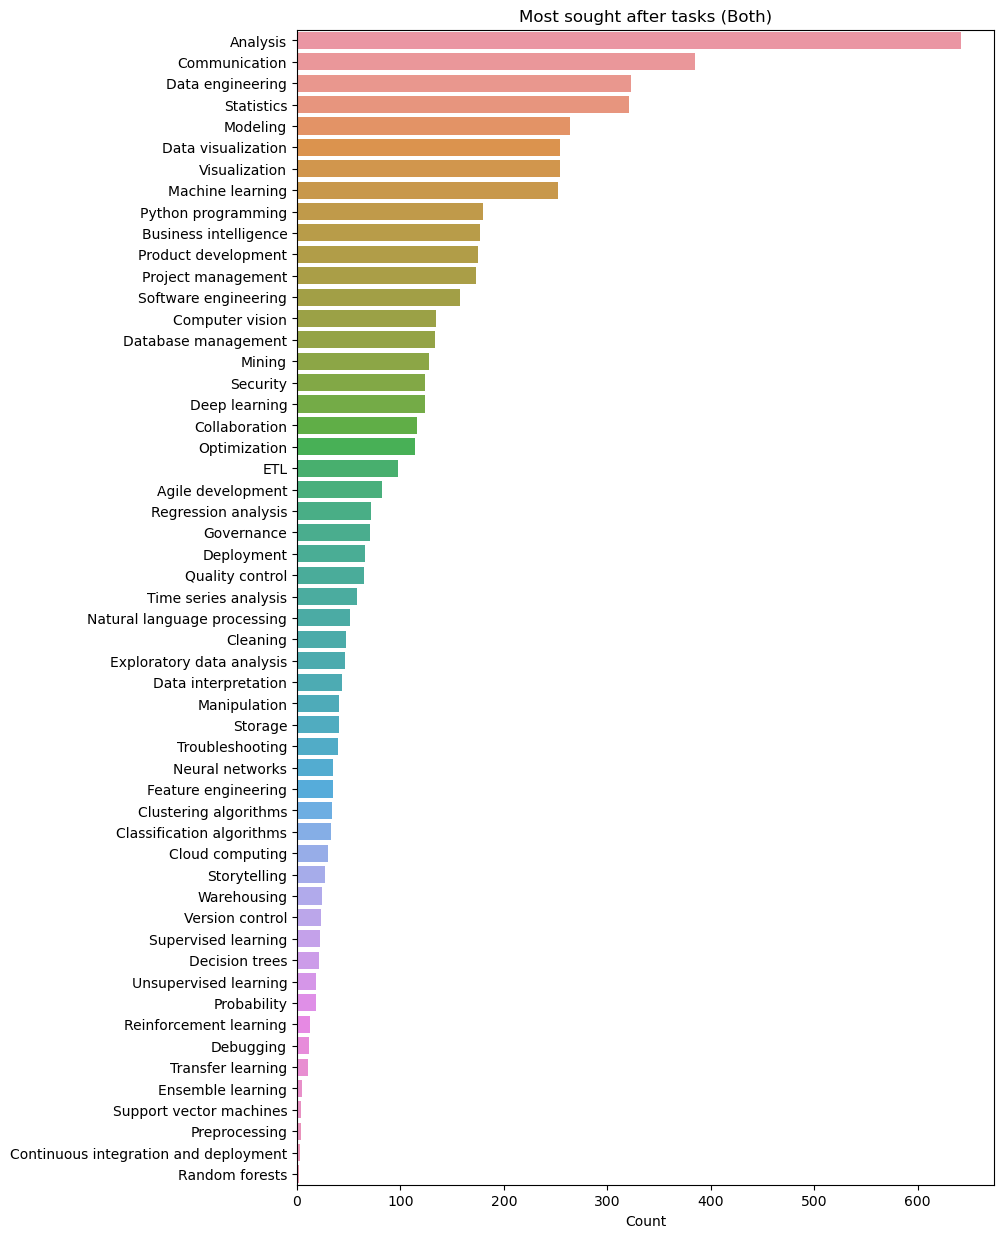

In [31]:
dataset_dict = {}

for index, row in dataset.iterrows():
    for i in row["tasks"]:
        if i in dataset_dict:
            dataset_dict[i] += 1
        else:
            dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after tasks (Both)")
plt.xlabel("Count")
plt.show()

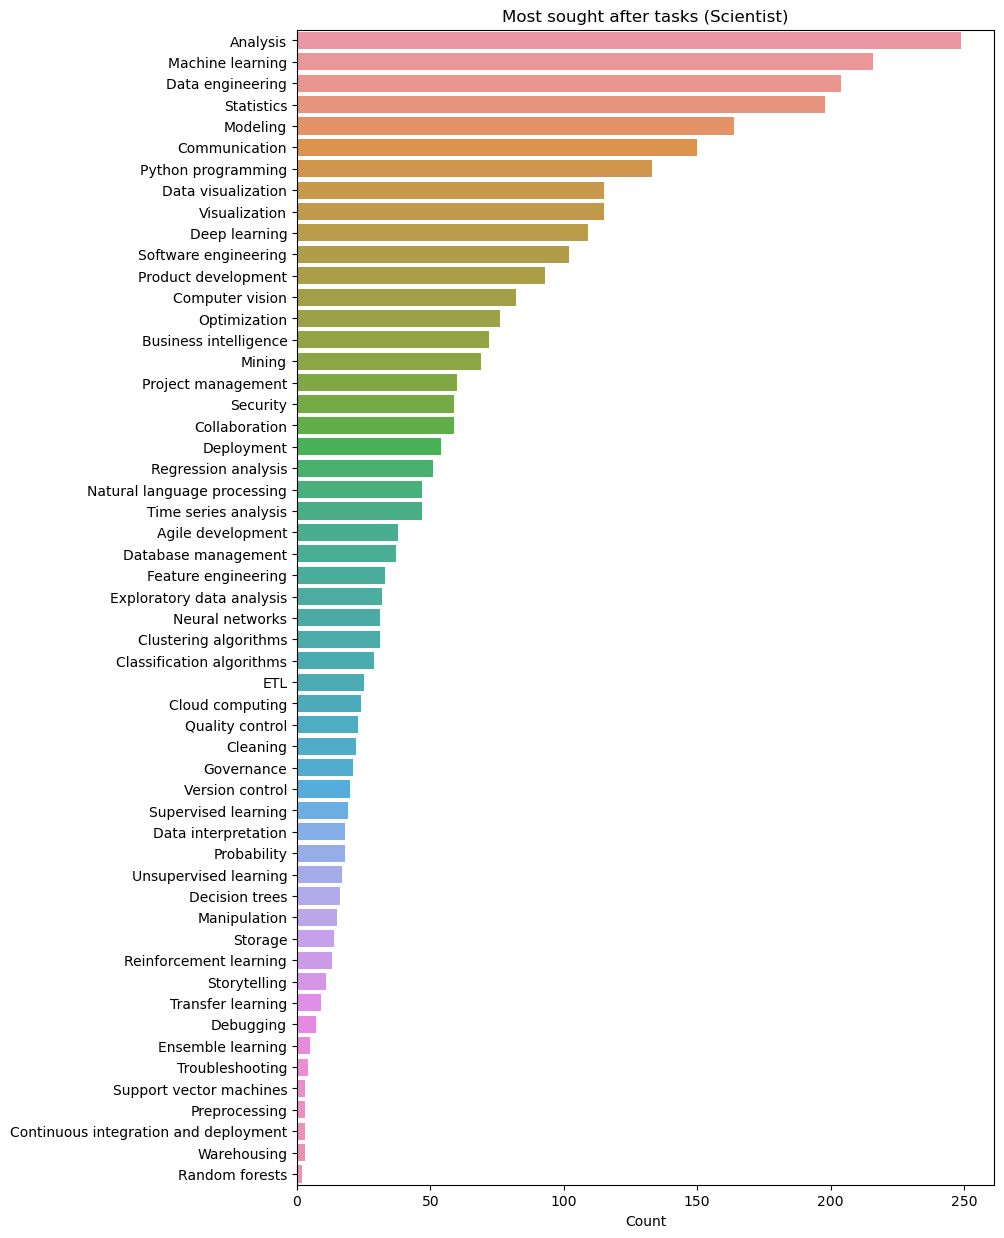

In [32]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Scientist":
        for i in row["tasks"]:
            if i in dataset_dict:
                dataset_dict[i] += 1
            else:
                dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after tasks (Scientist)")
plt.xlabel("Count")
plt.show()

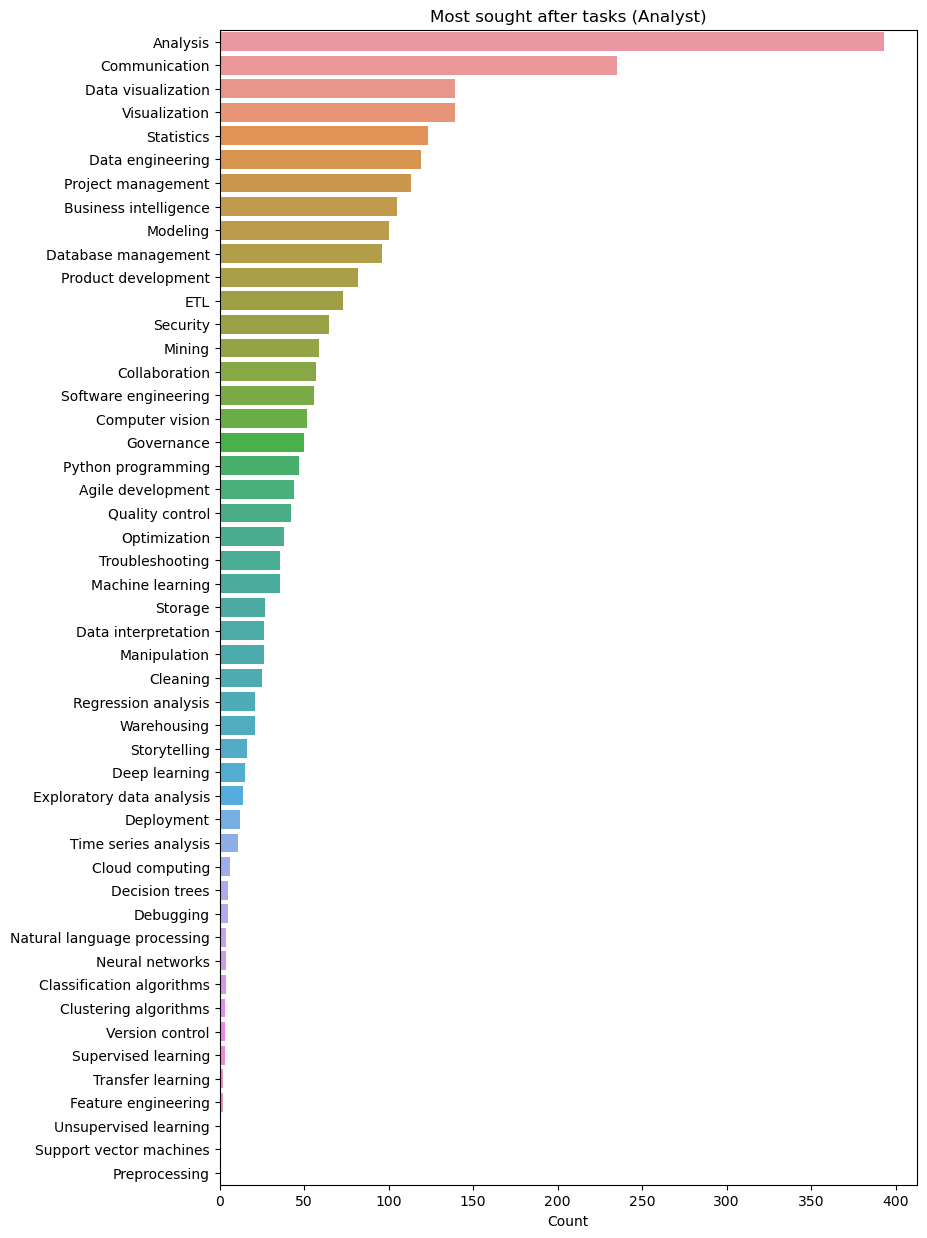

In [33]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Analyst":
        for i in row["tasks"]:
            if i in dataset_dict:
                dataset_dict[i] += 1
            else:
                dataset_dict[i] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (9, 15))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Most sought after tasks (Analyst)")
plt.xlabel("Count")
plt.show()

In [34]:
dataset.head()

,title,company,announcement,description,job,skills,tasks
0,Senior Data Scientist,TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build...",Scientist,"[R, SQL, Python, Scikit-Learn, Excel]","[Statistics, Regression analysis, Data engineering, Mining, Modeling, Time series analysis, Anal..."
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000...",Scientist,"[PySpark, AWS, SQL, Python, Pandas, Power BI, NumPy, Scikit-Learn, Excel]","[Statistics, Visualization, Data engineering, Feature engineering, Neural networks, Analysis, Ma..."
2,Lead Data Scientist,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c...",Scientist,[],"[Statistics, Data engineering, Modeling, Project management, Analysis, Machine learning, Collabo..."
3,Intern Data Scientist,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...,Scientist,"[Scikit-Learn, Excel]","[Visualization, Modeling, Project management, Business intelligence, Data visualization]"
4,Staff Data Scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to...",Scientist,"[R, Plotly]","[Computer vision, Statistics, Visualization, Modeling, Cleaning, Project management, Analysis, M..."


### Analyse Years of Experience

In [35]:
years_of_exp = ["1 years","2 years","3 years","4 years","5 years","6 years","7 years","8 years","9 years","10 years"]

# Create new column for experience
dataset["experience"] = "N/A"

In [36]:
for index, row in dataset.iterrows():
    matched_phrase = []
    
    sub_descriptions = row["description"].split(".")
    
    for sub_desc in sub_descriptions:
        if "exp" in sub_desc:
            for years in years_of_exp:
                if fuzz.token_set_ratio(sub_desc, years) >= 95:
                    matched_phrase.append(years)  
    
    # Only return matches once
    unique_matches = list(set(matched_phrase))
    unique_matches.sort(key=lambda s: (len(s), s))
    
    if len(unique_matches) > 0:        
        row["experience"] = unique_matches[0]
    else:
        row["experience"] = "N/A"
        
    displayProgress(index, len(dataset))

789/790 checks completed (99.873%)

In [37]:
dataset.head()

,title,company,announcement,description,job,skills,tasks,experience
0,Senior Data Scientist,TransUnion,The Muse,"transunion's job applicant privacy notice what we'll bring... at transunion, we strive to build...",Scientist,"[R, SQL, Python, Scikit-Learn, Excel]","[Statistics, Regression analysis, Data engineering, Mining, Modeling, Time series analysis, Anal...",1 years
1,Senior Data Scientist,"Grubhub Holdings, Inc.",ZipRecruiter,"about the opportunity we're all about connecting hungry diners with our network of over 300,000...",Scientist,"[PySpark, AWS, SQL, Python, Pandas, Power BI, NumPy, Scikit-Learn, Excel]","[Statistics, Visualization, Data engineering, Feature engineering, Neural networks, Analysis, Ma...",3 years
2,Lead Data Scientist,Discover Financial Services,LinkedIn,"discover. a brighter future. with us, you’ll do meaningful work from day 1. our collaborative c...",Scientist,[],"[Statistics, Data engineering, Modeling, Project management, Analysis, Machine learning, Collabo...",2 years
3,Intern Data Scientist,AbelsonTaylor,Startup Jobs,are you a 2023 college graduate or rising college senior? abelsontaylor is looking for 9 chicago...,Scientist,"[Scikit-Learn, Excel]","[Visualization, Modeling, Project management, Business intelligence, Data visualization]",N/A
4,Staff Data Scientist,NORC at the University of Chicago,SimplyHired,"job description: at norc, data scientists play a key role in working with our research teams to...",Scientist,"[R, Plotly]","[Computer vision, Statistics, Visualization, Modeling, Cleaning, Project management, Analysis, M...",2 years


In [38]:
dataset["experience"].value_counts().sort_index()

1 years      77
10 years      6
2 years     165
3 years     110
4 years      42
5 years      86
6 years      12
7 years      17
8 years      10
9 years       2
N/A         263
Name: experience, dtype: int64

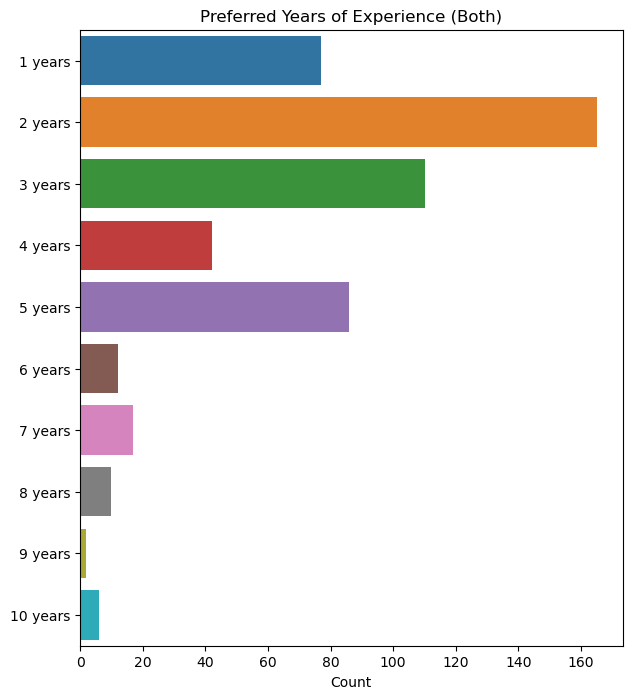

In [39]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["experience"] != "N/A":
        if row["experience"] in dataset_dict:
            dataset_dict[row["experience"]] += 1
        else:
            dataset_dict[row["experience"]] = 1

dataset_dict = dict(sorted(dataset_dict.items(), key=lambda s: (len(s[0]), s)))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 8))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred Years of Experience (Both)")
plt.xlabel("Count")
plt.show()

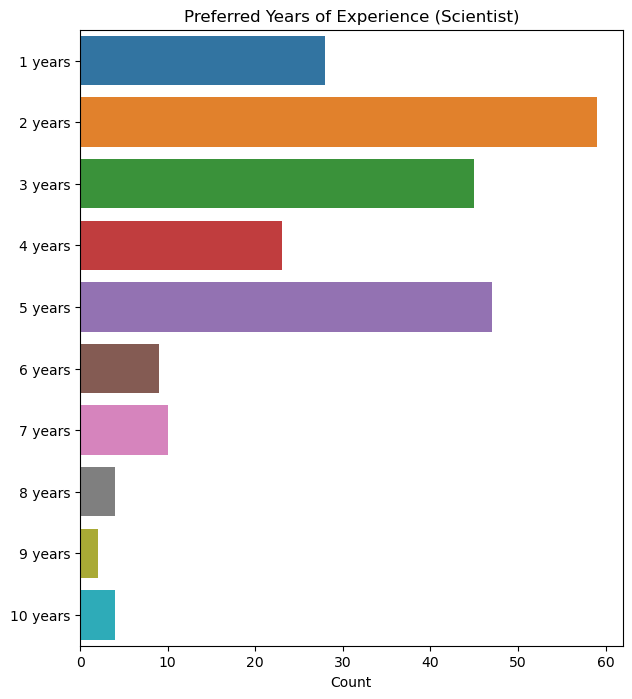

In [40]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Scientist":
        if row["experience"] != "N/A":
            if row["experience"] in dataset_dict:
                dataset_dict[row["experience"]] += 1
            else:
                dataset_dict[row["experience"]] = 1

dataset_dict = dict(sorted(dataset_dict.items(), key=lambda s: (len(s[0]), s)))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 8))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred Years of Experience (Scientist)")
plt.xlabel("Count")
plt.show()

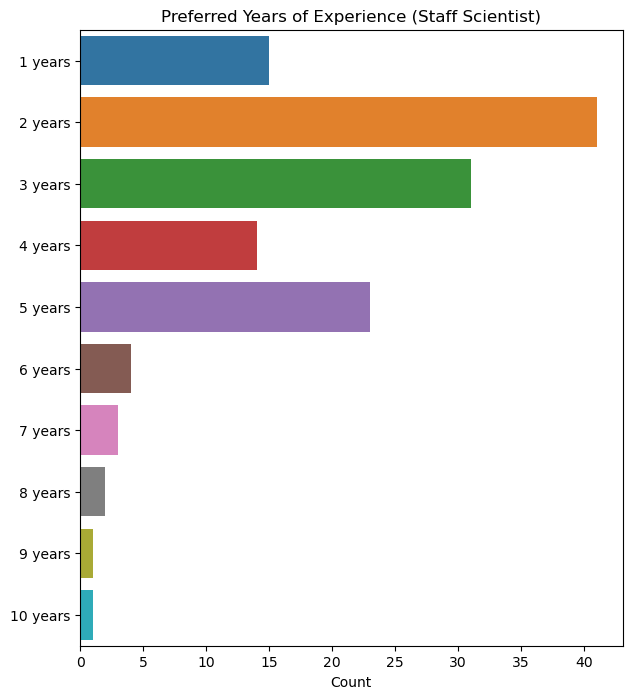

In [41]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Scientist" and "Staff" in row["title"]:
        if row["experience"] != "N/A":
            if row["experience"] in dataset_dict:
                dataset_dict[row["experience"]] += 1
            else:
                dataset_dict[row["experience"]] = 1

dataset_dict = dict(sorted(dataset_dict.items(), key=lambda s: (len(s[0]), s)))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 8))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred Years of Experience (Staff Scientist)")
plt.xlabel("Count")
plt.show()

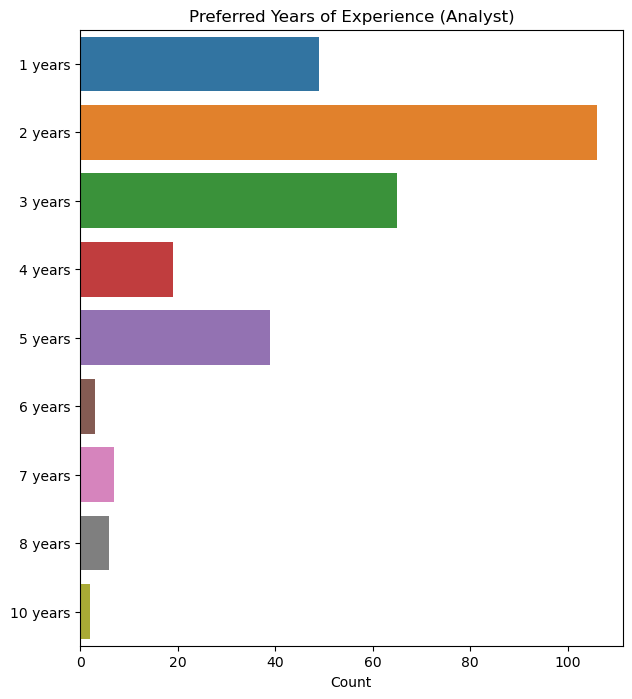

In [42]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Analyst":
        if row["experience"] != "N/A":
            if row["experience"] in dataset_dict:
                dataset_dict[row["experience"]] += 1
            else:
                dataset_dict[row["experience"]] = 1

dataset_dict = dict(sorted(dataset_dict.items(), key=lambda s: (len(s[0]), s)))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 8))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred Years of Experience (Analyst)")
plt.xlabel("Count")
plt.show()

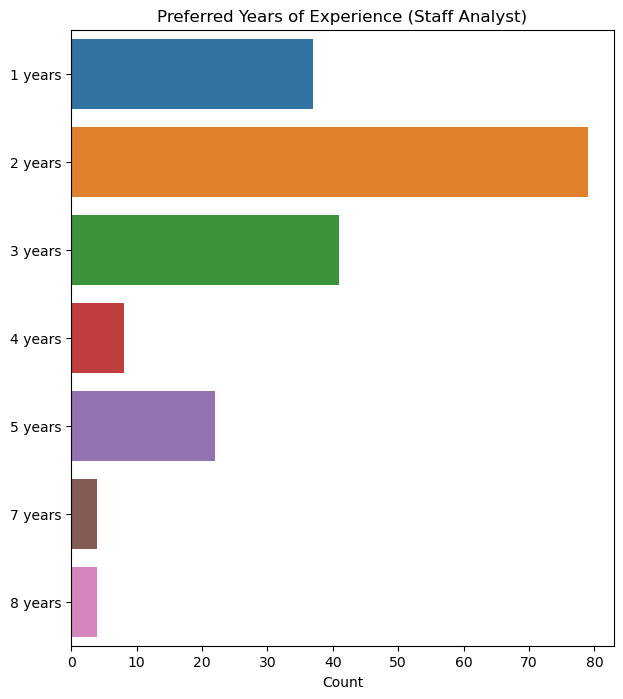

In [43]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Analyst" and "Staff" in row["title"]:
        if row["experience"] != "N/A":
            if row["experience"] in dataset_dict:
                dataset_dict[row["experience"]] += 1
            else:
                dataset_dict[row["experience"]] = 1

dataset_dict = dict(sorted(dataset_dict.items(), key=lambda s: (len(s[0]), s)))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 8))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred Years of Experience (Staff Analyst)")
plt.xlabel("Count")
plt.show()

### Analyse Education level

Level of Educations

- Bachelor - bs, bachelor
- Master - ms, master
- PhD - phd, doctorate

In [44]:
education_levels = {'bs': ['bs', 'bachelor'],
                    'ms': ['ms', 'master'],
                    'phd': ['phd', 'doctorate']}

dataset["education"] = "N/A"

In [46]:
for index, row in dataset.iterrows():    
    education_score = 0
    education_level = "N/A"
    
    for key, value in education_levels.items():        
        fuzz_score = 0
        
        for i in range(len(value)):
            # using tsr for abbreviation
            if i == 0:
                fuzz_score += fuzz.token_set_ratio(row["description"], value[i])
            # using ptsr for abbreviation
            elif i == 1:
                fuzz_score += fuzz.partial_token_set_ratio(row["description"], value[i])
        
        if education_score < fuzz_score:
            education_score = fuzz_score
            education_level = education_levels[key][1]
            
    row["education"] = education_level
    
    displayProgress(index, len(dataset))

789/790 checks completed (99.873%)

In [47]:
dataset["education"].value_counts()

bachelor     429
master       196
doctorate    165
Name: education, dtype: int64

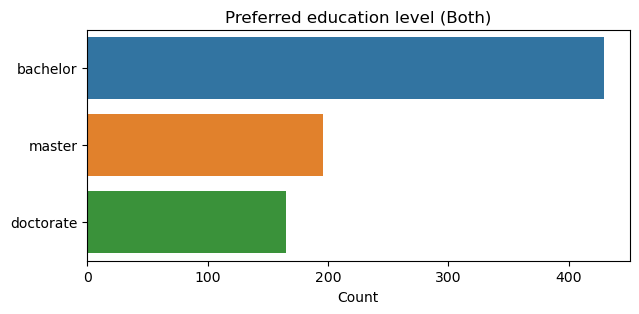

In [48]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["education"] in dataset_dict:
        dataset_dict[row["education"]] += 1
    else:
        dataset_dict[row["education"]] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 3))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred education level (Both)")
plt.xlabel("Count")
plt.show()

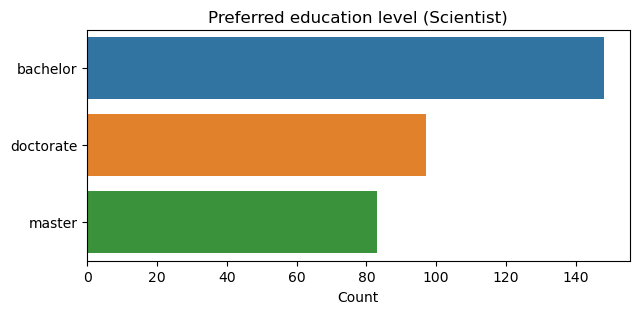

In [49]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Scientist":
        if row["education"] in dataset_dict:
            dataset_dict[row["education"]] += 1
        else:
            dataset_dict[row["education"]] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 3))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred education level (Scientist)")
plt.xlabel("Count")
plt.show()

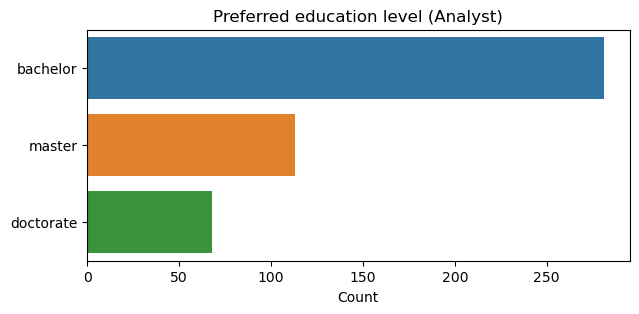

In [50]:
dataset_dict = {}

for index, row in dataset.iterrows():
    if row["job"] == "Analyst":
        if row["education"] in dataset_dict:
            dataset_dict[row["education"]] += 1
        else:
            dataset_dict[row["education"]] = 1

dataset_dict = dict(reversed(sorted(dataset_dict.items(), key = lambda x: x[1])))

keys = list(dataset_dict.keys())    
values = [dataset_dict[k] for k in keys]

plt.figure(figsize = (7, 3))
sns.barplot(x = values, y = keys, orient = "h")

plt.title("Preferred education level (Analyst)")
plt.xlabel("Count")
plt.show()

### ML

- feature variables = skills, tasks
- target variable = job

### Only using skills and tasks columns as features

In [51]:
sub_dataset = dataset[["job"]].copy(deep=True)

In [52]:
sub_dataset.head()

,job
0,Scientist
1,Scientist
2,Scientist
3,Scientist
4,Scientist


In [53]:
def ManualOneHotEnc(row):
    if row == "Scientist":
        return 1
    elif row == "Analyst":
        return 0

In [54]:
sub_dataset["job"] = sub_dataset["job"].apply(lambda x: ManualOneHotEnc(x))

In [55]:
def CombineSkillSets(skills, tasks):
    return " ".join(skills + tasks)

In [56]:
sub_dataset["skillsets"] = dataset.apply(lambda x: CombineSkillSets(skills = x[dataset.columns.get_loc("skills")],
                                                                    tasks = x[dataset.columns.get_loc("tasks")]),
                                         axis = 1)

In [57]:
sub_dataset = sub_dataset[["skillsets", "job"]]

In [58]:
sub_dataset.head()

,skillsets,job
0,R SQL Python Scikit-Learn Excel Statistics Regression analysis Data engineering Mining Modeling ...,1
1,PySpark AWS SQL Python Pandas Power BI NumPy Scikit-Learn Excel Statistics Visualization Data en...,1
2,Statistics Data engineering Modeling Project management Analysis Machine learning Collaboration ...,1
3,Scikit-Learn Excel Visualization Modeling Project management Business intelligence Data visualiz...,1
4,R Plotly Computer vision Statistics Visualization Modeling Cleaning Project management Analysis ...,1


### Creating Bag of Words model

In [59]:
cv = CountVectorizer()
x = cv.fit_transform(sub_dataset["skillsets"]).toarray()
y = sub_dataset["job"].values

In [60]:
x

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [61]:
print(cv.get_feature_names_out())
print(len(x[0]))
len(cv.get_feature_names_out())

['agile' 'ai' 'algorithms' 'analysis' 'and' 'apache' 'auto' 'aws' 'azure'
 'beautifulsoup' 'bi' 'business' 'caffe' 'classification' 'cleaning'
 'cloud' 'clustering' 'collaboration' 'communication' 'computer'
 'computing' 'continuous' 'control' 'dash' 'data' 'database' 'debugging'
 'decision' 'deep' 'deployment' 'development' 'engineering' 'ensemble'
 'etl' 'excel' 'exploratory' 'feature' 'flask' 'forests' 'gensim'
 'geopandas' 'ggplot' 'git' 'google' 'governance' 'h2o' 'hadoop' 'ibm'
 'integration' 'intelligence' 'interpretation' 'java' 'jupyter' 'keras'
 'language' 'learn' 'learning' 'lightgbm' 'linux' 'machine' 'machines'
 'management' 'manipulation' 'matplotlib' 'mining' 'modeling' 'natural'
 'networks' 'networkx' 'neural' 'nltk' 'numpy' 'opencv' 'optimization'
 'pandas' 'plotly' 'power' 'preprocessing' 'probability' 'processing'
 'product' 'programming' 'project' 'pyspark' 'python' 'pytorch' 'quality'
 'random' 'regression' 'reinforcement' 'scikit' 'scipy' 'seaborn'
 'security' 'se

120

### Train Test Set

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, shuffle = True)

### Training model

In [63]:
def training_model(x_train, x_test, y_train, y_test, model, metrics, **kwargs):
    trained_model = eval(model)(**kwargs)
    trained_model.fit(x_train, y_train)
    
    y_pred = trained_model.predict(x_test)
    
    perf = {i: eval(i)(y_test, y_pred) for i in metrics}
    perf_stats = pd.Series(list(perf.values()), index = list(perf.keys()), name = model)
    
    cm = confusion_matrix(y_test, y_pred)
    cm = np.vstack((cm[1][::-1], cm[0][::-1]))
    
    return trained_model, perf_stats, cm

In [64]:
model_metrics = ["accuracy_score", "precision_score", "recall_score", "f1_score"]

In [65]:
gnb, gnb_stats, gnb_cm = training_model(x_train, x_test, y_train, y_test, model="GaussianNB", metrics = model_metrics)

In [66]:
gnb_stats

accuracy_score     0.765823
precision_score    0.868421
recall_score       0.507692
f1_score           0.640777
Name: GaussianNB, dtype: float64

In [67]:
print(pd.concat([gnb_stats], axis=1).T)

            accuracy_score  precision_score  recall_score  f1_score
GaussianNB        0.765823         0.868421      0.507692  0.640777


### Testing Predictions

In [68]:
def JobMatch(cv, trained_model, profile):
    profile_transformed = cv.transform([profile]).toarray()
    result = trained_model.predict(profile_transformed)
    
    if result[0] == 1:
        return "Data Scientist"
    elif result[0] == 0:
        return "Data Analyst"

In [69]:
profile_1 = """Ability to Multitask 
Ability To Work Independently 
Able To Work Independently 
Agile Software Development 
Algorithm Design 
Analytic Problem Solving 
Analytical Problem Solving 
Applied Mathematics 
Artificial Neural Networks 
Attention to Detail 
Attention to Details 
Communication 
Data Analysis 
Data Cleaning 
Data Collection and Analysis 
Data Engineering 
Data Management 
Data Mining 
Data Modeling 
Data Quality 
Data Transformation 
Data Visualisation 
Data Visualization 
Decision Making 
Deep learning 
Financial Modelling 
hardworking 
Highly Resourceful 
Image Processing 
Information Technology 
Interpersonal Skills 
JavaScript 
Microsoft Excel 
Microsoft Power BI 
Microsoft SQL Server 
Multithreading 
Object oriented development 
Open Source 
Pattern Recognition 
Power BI 
PowerPoint 
Predictive Analysis 
Predictive Modeling 
Presentation Skills 
Problem Solving 
Product Design 
Product Management 
Program Development 
Programming 
Project Management 
Python 
Python Programming 
Python scripting 
Quantitative Analytics 
Requirements Gathering 
Research and Development 
Software Development 
Software Engineering 
SQL Server 
Statistical Programming 
System Design 
Troubleshooting 
User Experience 
Verbal Communication 
Virtualization 
Visual Studio 
Visualization 
Web Applications 
Web Development 
Web Performance 
Written Communication"""

In [70]:
JobMatch(cv=cv, trained_model=gnb, profile=profile_1)

'Data Scientist'